#**Abstracto:**



>El objetivo de este trabajo es generar un modelo de rankeo que permita elegir los mejores candidatos en un Draft para una liga de Fantasy de Basketball de la NBA. La data a utilizar fue extraída y organizada  de la página Basketball Reference donde se consideraron las estadísticas promedio de todos los jugadores de la liga. Se tomaron 3 temporadas de la nba desde el 2020 al 2023.

> Los modelos de rankeo suelen considerarse un subtipo de*** problema de clasificación supervisada*** que permite ordenar y extraer información futura de una manera óptima, relevante y funcional. En nuestro caso elegir los mejores jugadores para un fantasy. ***La variable target u objetivo sería el número de ranking o index*** que vamos a generar para sortear el dataset. Para lograr este objetivo podemos elegir entre los llamados métodos learning to Rank, que usan como modelo de base Descision Trees o Redes Neuronales. Cómo también podemos utilizar una técnica de la estadística espacial llamada Indexes de Composición muy utilizados en los mercados financieros o en las ciencias sociales.

> El fantasy es una competencia de 10 categorías, por método de *Head to Head*, donde dos equipos se enfrentan cada semana y después el que haya acumulado mejor puntaje en cada categoría gana esa semana.
> La liga es de 12 participantes donde se seleccionan 13 atletas en el Draft, lo que significa que en total se seleccionan 156 de unos 540 jugadores disponibles dependiendo de la temporada.

>Hay restricciones posicionales a la hora de hacer el Draft, sólo se puede tener tener 4 centros, y cada semana solo se pueden "jugar" 10 individuos, 3 Utils que pueden ser de cualquier posición y un Point Guard *(PG)*, un Shooting Guard *(SG)*, un Small Fordward (SF), un Power Foward (*PF*), un Centro (*C*), un Fordward (*F*) que puede ser un *PF* o un *SF* o un Guard (G) que puede ser
un *PG* o un *SG*.

> Las categorías son: Puntos (*PTS*), Porcentaje de Tiros (*FG%*), Porcentaje de Tiro Libre (*FT%*), Triples Logrados (*3PM*), Rebotes (*RB*), Asistencias (*AST*), Robos (*ST*), Bloqueos (*BLK*), Perdidas (*TO*) y Dobles Dobles (*DD*),que consiste en lograr diez puntos y diez rebotes o asistencias resultando en un doble doble.

> La base de datos proporciona varias variables, adicionales a las categorías del fantasy, que permiten afinar el modelo. Por ejemplo, los minutos jugados promedio (*MP*) pueden utilizarse para descartar jugadores con muy poco minutos de juego que afecten la calidad del modelo. Otras variables como el Player Efficency Rating (*PER*); que es una variable sintética creada para medir la eficiencia de un jugador en la cancha -considerando un aporte de su equipo y la calidad de la competencia-, podría analizarse para ver si es un buen predictor de que el jugador en cuestión sea superior al promedio en las categorías pertinentes. El True Shooting Percentage (*TSP%*) que es un promedio entre el porcentaje de tiros libres (*FT%*), tiros a campo  (*FG%*) y tiros de 3  (*3PFG%*) logrados por de un jugador. Por último, también es necesario considerar la posicionalidad, en el sentido que ciertas posiciones tenga más o menos jugadores que aporten un valor mayor al promedio, presentando un costo de reposición más alto.

> Finalmente el modelo debe poder rankear una lista de datos de jugadores, ,asumiendo las mismas condiciones y categorías de la liga, con las proyecciones estadísticas que se dan cada año.








In [ ]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib



In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/drive/MyDrive'
df = pd.read_csv('nba_stats.csv')

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
df23 = df[df['season']== 2023]
df23['Player'].describe()
df.columns


Index(['Unnamed: 0', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'season', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS',
       'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%',
       'USG%', 'VORP', 'WS', 'WS/48'],
      dtype='object')

In [ ]:
df.shape

(4379, 52)

###Análisis de las Categorías:


*  Categorías faltantes: Dobles Dobles, se logra cuando un jugador hace 10 puntos y 10 rebotes o asistencias.






In [ ]:
#Agregamos la columna de Dobles Dobles. Se puede elegir entre el valor más alto entre rebotes, asistencias y puntos o hacer un promedio entre ellos.
#Para este caso vamos a elegir el mayor numero entre rebotes o asistencias.


conditions = [(df['PTS'] >= 10) & (df['TRB']>df['AST']),(df['PTS'] >= 10) & (df['TRB']<df['AST']),(df['PTS'] < 10) & (df['TRB']>df['AST']),
              (df['PTS'] < 10) & (df['TRB']<df['AST'])]

values= [(df['TRB']/10), (df['AST']/10), (df['TRB']/df['PTS']), (df['AST']/df['PTS'])]
df['DD']= np.select(conditions, values)

df.head(5)

,Unnamed: 0,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,DD
0,0,Álex Abrines,SG,24.0,OKC,75.0,8.0,15.1,1.5,3.9,...,9.0,1.7,7.4,5.6,0.567,12.7,0.1,2.2,0.094,0.319149
1,1,Quincy Acy,PF,27.0,BRK,70.0,8.0,19.4,1.9,5.2,...,8.2,1.2,13.3,10.0,0.525,14.4,-0.2,1.0,0.036,0.627119
2,2,Steven Adams,C,24.0,OKC,76.0,76.0,32.7,5.9,9.4,...,20.6,1.8,13.3,15.3,0.630,16.7,2.0,9.7,0.187,0.900000
3,3,Bam Adebayo,C,20.0,MIA,69.0,19.0,19.8,2.5,4.9,...,15.7,1.2,13.6,15.6,0.570,15.9,0.6,4.2,0.148,0.797101
4,4,Arron Afflalo,SG,32.0,ORL,53.0,3.0,12.9,1.2,3.1,...,5.8,0.3,10.8,5.3,0.516,12.5,-0.6,0.1,0.009,0.352941


In [ ]:


# Voy a verificar que no haya divisiones entre cero y si hay las sustituyo por NaN
print()
print("printing the count of infinity values")

count = np.isinf(df['DD']).values.sum()
print("It contains " + str(count) + " infinite values")

df.replace([np.inf, -np.inf], np.nan, inplace=True)
count = np.isinf(df['DD']).values.sum()
print("It contains " + str(count) + " infinite values")


printing the count of infinity values
It contains 47 infinite values
It contains 0 infinite values


De esta manera ya puedo utilizar la categoría de doble doble en mi análisis.

Cantidad de posiciones en el Dataset

In [ ]:
#Primero veo que posiciones están en el dataset
print(df['Pos'].unique())
multi_pos_plyrs = df[~df['Pos'].isin(['SG','PG','PF','SF','C'])]
print(len(multi_pos_plyrs['Pos'].dropna()))
print(df.columns)

['SG' 'PF' 'C' 'PG' 'SF' nan 'SF-SG' 'PG-SG' 'PF-SF' 'SG-PF' 'C-PF'
 'SG-SF' 'PF-C' 'SF-C' 'SF-PF' 'SG-PG' 'SG-PG-SF']
61
Index(['Unnamed: 0', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'season', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS',
       'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%',
       'USG%', 'VORP', 'WS', 'WS/48', 'DD'],
      dtype='object')




> hay algunos jugadores que tienen multiposicionalidad hay que ver si a estos juagadores, ya que son sólo 61, sería mejor descartarlos del set o se podrían contabilizar una vez por cada una de las posiciones que pueden jugar.



In [ ]:
# Antes de tomar esa desición separamos a esos jugadores del set para poder hacer comparaciones adecuadas
single_pos_plyrs = df[df['Pos'].isin(['SG','PG','PF','SF','C'])]

Puntos por Numero de Jugadores

0        4.7
1        5.9
2       13.9
3        6.9
4        3.4
        ... 
4374     4.4
4375    26.2
4376     4.4
4377     6.5
4378    10.8
Name: PTS, Length: 4379, dtype: float64


<Figure size 800x600 with 0 Axes>

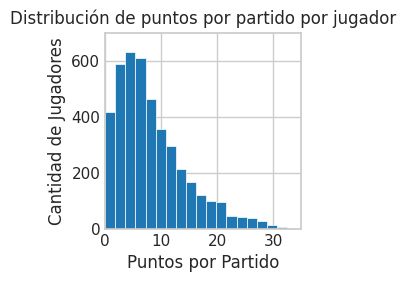

In [ ]:

plt.figure(figsize=(8, 6))
plt.style.use('_mpl-gallery')


x = df['PTS']
print(x)
# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=20, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 35),
       ylim=(0, 700))
ax.set_xlabel('Puntos por Partido')
ax.set_ylabel('Cantidad de Jugadores')
ax.set_title('Distribución de puntos por partido por jugador')

plt.show()

In [ ]:
a



> La basta mayoría de jugadores promedian menos de veinte puntos por partido. Pero también es una de las categorías que tiene una número de mayor tamaño en relación al promedio de robos, bloqueos o números de triple.



0       0.5
1       0.5
2       1.2
3       0.5
4       0.1
       ... 
4374    1.0
4375    1.1
4376    0.2
4377    0.2
4378    0.4
Name: STL, Length: 4379, dtype: float64


<Figure size 800x600 with 0 Axes>

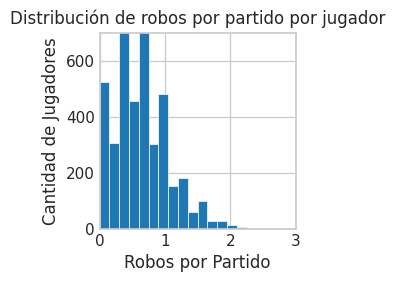

In [ ]:

plt.figure(figsize=(8, 6))
plt.style.use('_mpl-gallery')


x = df['STL']
print(x)
# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=20, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 3),
       ylim=(0, 700))
ax.set_xlabel('Robos por Partido')
ax.set_ylabel('Cantidad de Jugadores')
ax.set_title('Distribución de robos por partido por jugador')

plt.show()



> En el gráfico parecería que a diferencia de los puntos los robos no siguen una distribución relativamente normal



Ratio entre Pérdidas  por la cantidad de Asistencias.


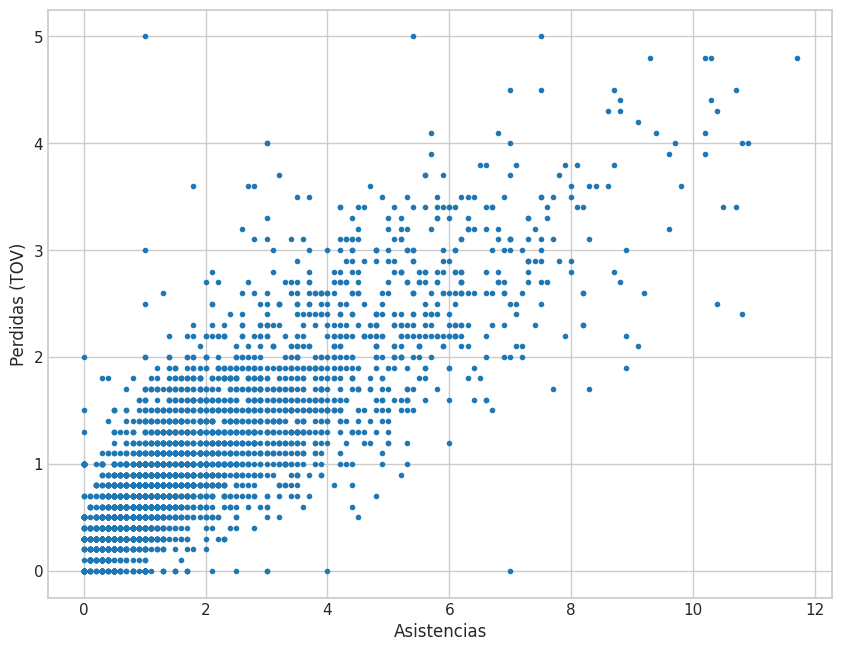

In [ ]:

tov_stats = df.filter(items=['AST', 'TOV'])



plt.figure(figsize=(8, 6))
plt.scatter('AST','TOV', data=tov_stats, marker="." )
plt.xlabel('Asistencias')
plt.ylabel('Perdidas (TOV)')
plt.show()



> A simple vista parece haber una fuerte correlación entre el número de asistencias y la cantidad de pérdidas del balón. Lo que significa que probablemte haya siempre un pequeño intercambio entre la cantidad de asistencias que quiero tener y las pérdidas. Evidentemente el modelo del ranking debería reflejarse positivamente aquellos jugadores que hacen asistencias sin muchas pérdidas. Esto me hace preguntarme como lidia uno con los outlier es un modelo que busca rankear esta lista de jugadores y se supone que estos jugadores que en teoría estarían de primero serían los que outlier de mi dataset que estan sobre la media entre todos los jugadores y dentro de su posición.

A continuación vamos a explorar estás mismas variables tomandando en cuenta la posición del jugador.



<Axes: xlabel='AST', ylabel='TOV'>

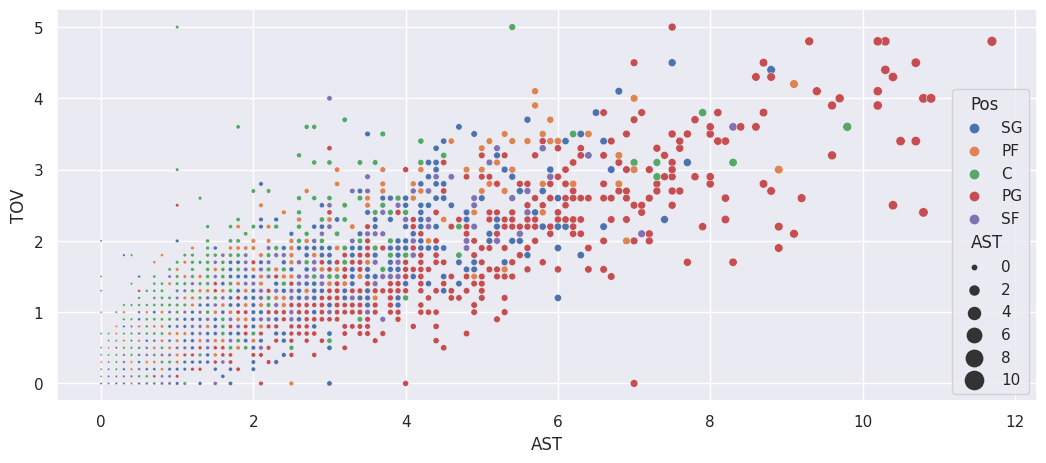

In [ ]:
sns.set(rc={"figure.figsize":(10, 4)})
steal_stats = single_pos_plyrs.filter(items=['AST','TOV', 'Pos'])

sns.scatterplot(data=steal_stats, x='AST', y='TOV', marker=".", hue='Pos', size='AST', sizes=(10, 200))



> En este gráfico podemos apreciar varias cosas:

*   La posicionalidad determina la cantidad de asistencias de una manera importante
*   Es fácil apreciar los outliers sobretodo en las posiciones que no son el Point Guard que es normal que sea la posición lider en asistencias


*   Ya a partir de 6 asistencias el número de jugadores que superan este promedio es muy reducido.








Gráfico Boxplot de Centros en 7 Cátegorías

['SG' 'PF' 'C' 'PG' 'SF' nan 'SF-SG' 'PG-SG' 'PF-SF' 'SG-PF' 'C-PF'
 'SG-SF' 'PF-C' 'SF-C' 'SF-PF' 'SG-PG' 'SG-PG-SF']
      STL   PF Pos   FG  TRB   AST   3P  BLK
8     0.2  0.8  PG  0.3  0.6   0.7  0.0  0.1
18    0.5  0.8  PG  0.7  1.0   1.5  0.4  0.0
26    0.7  1.3  PG  3.3  2.1   3.8  1.5  0.0
32    0.3  1.7  PG  2.0  1.1   0.7  0.6  0.1
33    1.7  2.3  PG  3.9  6.9   7.2  1.7  0.8
...   ...  ...  ..  ...  ...   ...  ...  ...
4343  1.1  2.0  PG  6.1  4.9   7.6  1.2  0.5
4350  0.0  1.0  PG  2.6  1.0   2.0  0.9  0.3
4371  1.8  1.2  PG  2.8  3.6   3.9  0.8  0.3
4372  0.3  0.9  PG  1.7  1.7   2.1  0.3  0.2
4375  1.1  1.4  PG  8.2  3.0  10.2  2.1  0.1

[789 rows x 8 columns]
Axes(0.01,0.01;0.98x0.98)


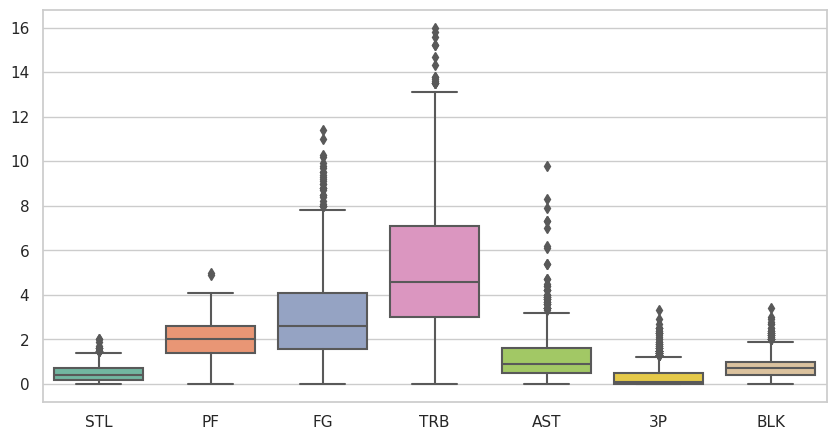

In [ ]:
stats_sevencat= df.filter(items=['STL','PF', 'Pos','FG','TRB', 'AST', '3P', 'BLK'])
stats_sevencatbypos= stats_sevencat.groupby('Pos')

sns.set_style('whitegrid')
sns.set_palette('Set2')
print(stats_sevencat['Pos'].unique())
print(stats_sevencat[stats_sevencat['Pos'] == 'PG'])

print(sns.boxplot(stats_sevencat[stats_sevencat['Pos']== 'C']) )



> Siento que este tipo de gráficos será más útil cuando limpie un poco la data y quite los datos nulos y los outliers porque debe haber una cantidad no despreciable que juega poco minutos y producen estadísticas muy bajas que al final se va a salir muy lejos de la población de jugadores que se eligen el fantasy que son aproximadamente 156.



> Esto también me hace preguntarme si debería castigar los datos outlier que estan por debajo del promedio que los que estan por arriba y como lidiar con los outlier es un ejercicio de ranking en general. Es posible que sea provechoso poner más temporadas para que cuando reduzca la muestra, por ejemplo en el caso de jugadores que juegan muy pocos minutos,todavía tenga 2000 filas de datos. Lo que me llevaría a tener que conseguir la data de por lo menos 13 temporadas pero quizas sea más util para mi modelo ya que en un Fantasy Promedio se eligen 156 jugadores más o menos. Habría que ver si esto haría el modelo más o menos útil.







Gráfico Boxplot de Point Guards en 7 Cátegorías

<Axes: >

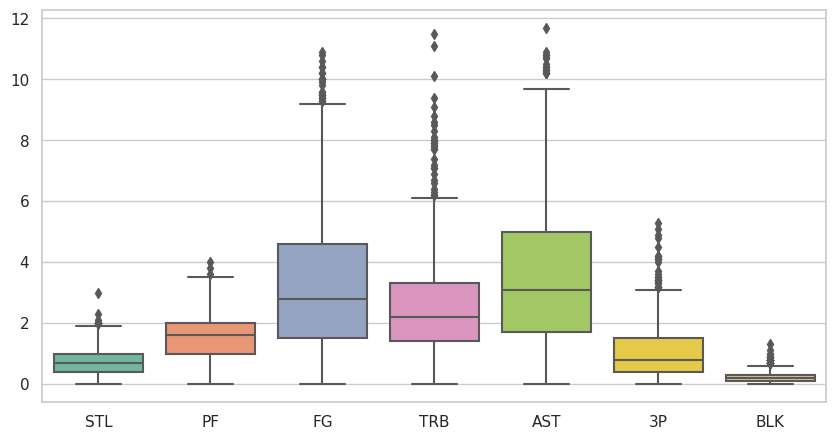

In [ ]:
sns.boxplot(stats_sevencat[stats_sevencat['Pos']== 'PG'])

También la concentración de las variables por categoría me parece que es una consideración importante a la de pesar las variables para el modelo. Deberían las variables como robos (STL) , bloqueos (BLK)y triples (3P)  que tienen una concentración muy grande oscilando sobre un valor, tener un peso menor que variables más "estables" como los puntos, rebotes y asistencias?

Estadísticas Promedio de un Centro en 7 Cátegorías

          STL        PF        FG      TRB       AST        3P       BLK  \
Pos                                                                        
C    0.484433  1.976339  3.076463  5.32528  1.230012  0.348817  0.748692   

          PTS         MP  
Pos                       
C    7.852304  17.504234  


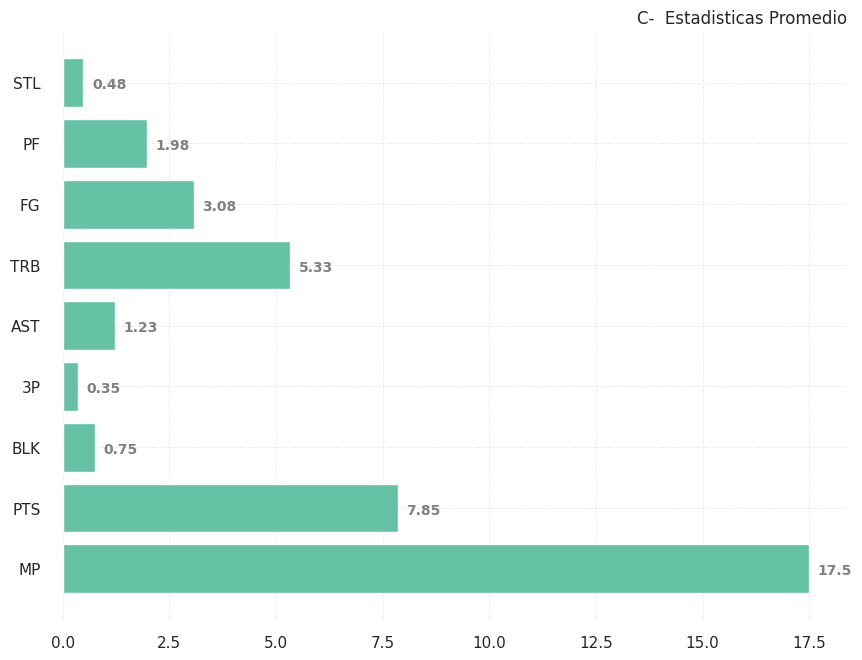

In [ ]:
stats_eightncat= single_pos_plyrs.filter(items=['STL','PF', 'Pos','FG','TRB', 'AST', '3P', 'BLK', 'PTS', 'MP'])
mean_8cat = stats_eightncat.groupby('Pos').mean()

fig, ax = plt.subplots(figsize =(8,6))


print(mean_8cat.iloc[mean_8cat.index == 'C'])

center_stats = mean_8cat.iloc[0]
stats_names = mean_8cat.columns

ax.barh(stats_names, center_stats)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid( color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('%s-  Estadisticas Promedio'%(mean_8cat.index[0]),
             loc ='right', )



# Show Plot
plt.show()

Puntos de 3 por Temporada

<Axes: xlabel='season', ylabel='3P'>

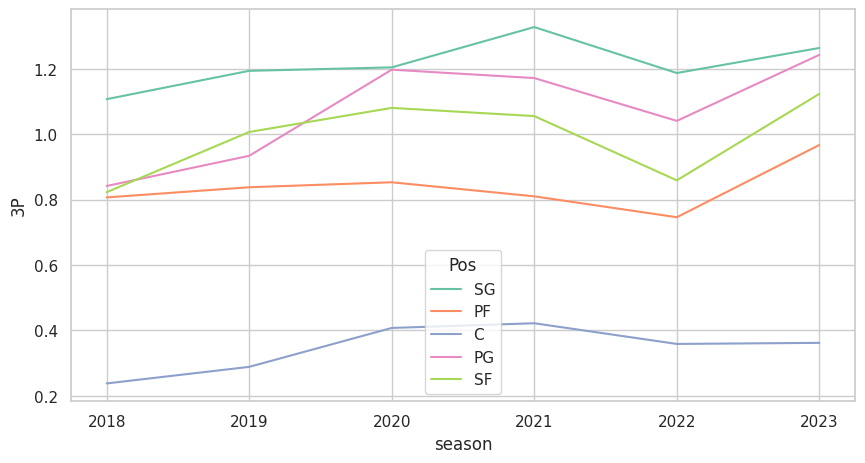

In [ ]:
sns.lineplot(data= single_pos_plyrs, x='season', y='3P' ,hue='Pos', err_style=None)



> Es evidente que los triples logrados por partido son una categoría que poseen una escasez posicional importante para los centros especialmente y  en menor medida en los Power Fowards (PF). Mi modelo debe poder rankear o premiar aquellos jugadores de una posición que me ofrezcan esta categoría que va a ser muy dificil de conseguir en su propia categoría.



Para resolver el probelma de rankear la lista de jugadores bajo las categorías previamente definidas también hay otras variables que pueden ser útiles como el Usage% o el PER. Un PCA o una regresión linear me podría permitir ver si debería considerar otras variables para alimentar mi modelo. El problema principal es determinar el pesos que cada variable debe tener dentro de modelo, es evidente que la posición es una variable calidad a la hora de determinar escasez o abundancia en una categoría determinada. Como probablemente creo que una regresión de los minutos jugados demuestre una fuerte relación con todas las categorías, excepto el Porcentaje de Tiro (FG%) y el de Tiros Libres(FT%). Estas variables porcentuales quizas deberían separarse en atentos y logros para que tengan un mayor peso los jugadores que tienen más intentos.